This is going to randomly sample, but then also return consective data points. both based on a dim

In [2]:
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class WaveformDataset(Dataset):
    def __init__(self, wav_data, t_input):
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

In [4]:
class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size


    
    

wav_data = np.linspace(1,100,100).tolist()  # Example waveform data
t_input = np.linspace(1,100,100).tolist()  # Example time step data

dataset = WaveformDataset(wav_data, t_input)
batch_size = 17
consecutive_size = 13

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)



In [89]:
def consecutive_dif(prediction, target, consecutive_size):
    """
    This will calculate the differences across consecutive points.  
    use RandomConsecutiveSampler for intended results
    """
    pred_reshape = prediction.view(-1,consecutive_size)
    target_reshape = target.view(-1,consecutive_size)
    pred_dif = pred_reshape[:,1:] - pred_reshape[:,:-1]
    target_dif = target_reshape[:,1:] - target_reshape[:,:-1]
    return torch.mean((pred_dif - target_dif)**2)

    
class ConsecutiveDifferenceLoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)
    
    
class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)

   
# variations.  you can do the differences with all the other consecutive points.  
# you could do differences along the batch.  those are consecutive points but they shift one each time
# weight those with the dif in t.  that could be interesting.  
#might add in another dataloader? a completely random one? what if you use mse on the random one? 
#thats interesting.  or maybe just weird.  
#no its interesting.  you learn the slopes from differences, then the vertical shift from mse on different points.  
# try these on a single wave to learn frequency.  then add in phi?

class ConsecutiveDifferenceLossAndBatch(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLossAndBatch, self).__init__()
        """
        This does the consecutive loss as well as the batch loss.  
        This does look consecutively differences across batches, i wonder how that will effect it.  
        
        """
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        
        pred_dif_batch = pred_reshape[1:, :] - pred_reshape[:-1, :]
        target_dif_batch = target_reshape[1:, :] - target_reshape[:-1, :]
        
        consec_loss = torch.mean((pred_dif - target_dif) ** 2)
        batch_loss = torch.mean((pred_dif_batch - target_dif_batch) ** 2)
        
        return consec_loss + batch_loss

    
class ConsecutiveSlopeWeightedMSELoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveSlopeWeightedMSELoss, self).__init__()
        """this is just mse weighted by how different the slope before and after the point is"""
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        #pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_slope = target_reshape[:, 1:] - target_reshape[:, :-1]
        
        target_slope_dif = target_slope[:, 1:] - target_slope[:, :-1]
        
        
        errors = pred_reshape[:,1:-1] - target_reshape[:,1:-1]
        
        return torch.mean(target_slope_dif **2 * errors **2)

class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[:, 1:]
        pred_b = pred_reshape[:, :-1]
        target_a = target_reshape[:, 1:]
        target_b = target_reshape[:, :-1]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[:, 1:]
            pred_b = pred_dif[:, :-1]
            target_a = target_dif[:, 1:]
            target_b = target_dif[:, :-1]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result

    
class ConsecutiveDifferenceHigherOrderLossBatch(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLossBatch, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[ 1:, :]
        pred_b = pred_reshape[:-1,:]
        target_a = target_reshape[ 1:, :]
        target_b = target_reshape[:-1,:]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[ 1:, :]
            pred_b = pred_dif[:-1,:]
            target_a = target_dif[ 1:, :]
            target_b = target_dif[:-1,:]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result
    
class WeightedMSELoss(nn.Module):
    def __init__(self,max_amp = 142.76):
        super(WeightedMSELoss, self).__init__()
        self.max_amp = max_amp
        
    def forward(self, predictions, targets):
        assert predictions.size() == targets.size(), "Size mismatch between predictions and targets"
        
        target_weights = (targets/self.max_amp) ** 2
        squared_error = (predictions - targets) ** 2
        
        weighted_error = target_weights * squared_error
        
        loss = torch.mean(weighted_error)
        return loss

In [173]:
class WeirdSinLayer(nn.Module):
    def __init__(self, init_mult = 1.0):
        super(WeirdSinLayer, self).__init__()
        
        self.param_A = nn.Parameter(torch.randn(1, 2)*init_mult)  # Amplitude
        self.param_phi = nn.Parameter(torch.randn(1, 2))  # Phase shift

    def forward(self, t):
        if t.dim() == 1:
            t = t.unsqueeze(-1)  #may not be necessary, i forget how my dataloader do it

        out_params = self.param_A * torch.sin( t + self.param_phi) 
        
        out_A = out_params[:, 0].unsqueeze(-1)  
        out_phi = out_params[:, 1].unsqueeze(-1)      
        
        out_t = out_A * torch.sin(t + out_phi)
        
        return out_t
    
class WeirdSinNetwork(nn.Module):
    def __init__(self, num_layers):
        super(WeirdSinNetwork, self).__init__()
        
        # Dynamically create the specified number of WeirdSinLayer layers
        self.layers = nn.ModuleList([WeirdSinLayer() for _ in range(num_layers)])

    def forward(self, t):
        # Pass the input through each layer in sequence
        for layer in self.layers:
            t = layer(t)
        return t
    
class WeirdSinNetworkInc(nn.Module):
    def __init__(self, num_layers,inc=0.1):
        super(WeirdSinNetworkInc, self).__init__()
        
        # Dynamically create the specified number of WeirdSinLayer layers
        self.layers = nn.ModuleList([WeirdSinLayer() for _ in range(num_layers)])
        for idx,layer in enumerate(self.layers):
            print(layer.param_A)
            additive = torch.tensor([50 - (idx* inc)]).unsqueeze(-1).float()
            layer.param_A = nn.Parameter(layer.param_A + additive)
            print(layer.param_A)

    def forward(self, t):
        # Pass the input through each layer in sequence
        for layer in self.layers:
            t = layer(t)
        return t
    
class WeirdSinNetworkInit1(nn.Module):
    def __init__(self, num_layers, last_a_init = 100.0):
        super(WeirdSinNetworkInit1, self).__init__()
        
        # Dynamically create the specified number of WeirdSinLayer layers
        self.last_a = torch.tensor([[last_a_init]])
        self.layers = nn.ModuleList([WeirdSinLayer(1.2) for _ in range(num_layers)])
        

    def forward(self, t):
        # Pass the input through each layer in sequence
        for layer in self.layers:
            t = layer(t)
        return self.last_a * torch.sin(t)
    



In [266]:
class BinarySinLayer(nn.Module):
    def __init__(self, embedding_dim=10):
        super(BinarySinLayer, self).__init__()
        
        self.param_A = nn.Parameter(torch.randn(embedding_dim, 2))  # Amplitude
        self.param_phi = nn.Parameter(torch.randn(embedding_dim, 2))  # Phase shift

    def forward(self, t):
        if t.dim() == 1:
            t = t.unsqueeze(1).unsqueeze(2) 
        if t.dim() == 2:
            t = t.unsqueeze(1) 
        out_params = self.param_A * torch.sin( t + self.param_phi) 
        
        out_A = out_params[:,:, 0].unsqueeze(-1)  
        out_phi = out_params[:,:, 1].unsqueeze(-1)      
        
        out_t = out_A * torch.sin(t + out_phi)

        return out_t
    
class WeirdSinPaintNetwork(nn.Module):
    def __init__(self, num_layers = 10, embedding_dim = 10):
        super(WeirdSinPaintNetwork, self).__init__()
        self.embedding = nn.Parameter(torch.randn(embedding_dim,1)*100).double()
        # Dynamically create the specified number of WeirdSinLayer layers
        self.layers = nn.ModuleList([BinarySinLayer(embedding_dim) for _ in range(num_layers)])
        

    def forward(self, t):
        # Pass the input through each layer in sequence
        for layer in self.layers:
            t = layer(t)
        t = 0.5 * torch.sin(t) + 0.5
        result = torch.matmul(t.transpose(1, 2), self.embedding)

        return result.squeeze(-1)
    
class WeirdSinPaintNetwork2(nn.Module):
    def __init__(self, num_layers = 10, embedding_dim = 10):
        super(WeirdSinPaintNetwork2, self).__init__()
        self.embedding = nn.Parameter(torch.randn(embedding_dim,1)*100).double()
        # Dynamically create the specified number of WeirdSinLayer layers
        self.layers = nn.ModuleList([BinarySinLayer(embedding_dim) for _ in range(num_layers)])
        

    def forward(self, t):
        # Pass the input through each layer in sequence
        for layer in self.layers:
            t = layer(t)
        t = torch.sin(t)
        result = torch.matmul(t.transpose(1, 2), self.embedding)

        return result.squeeze(-1)

In [259]:
bs = BinarySinLayer(20)
bs2 = BinarySinLayer(20)
test_t = torch.from_numpy(np.linspace(1,10,15))
#print(test_t.shape)
o = bs(test_t)

#print(o.shape)
o2 = bs2(o)
#print(o2.shape)
w = WeirdSinPaintNetwork(num_layers = 10, embedding_dim = 10)
print(w(test_t).shape)

torch.Size([15, 1])


In [7]:
def generate_gaussian_noise(outputs, mean=0, std_dev=1):


    
    # Get the shape of the outputs
    shape = outputs.shape
    
    
    # Generate Gaussian noise with the same shape as the outputs
    noise = torch.normal(mean=mean, std=std_dev, size=shape)
    
    return noise

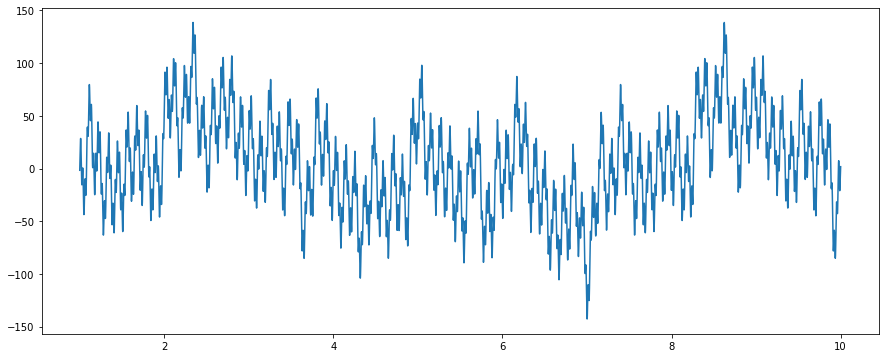

In [128]:

data_t = torch.from_numpy(np.linspace(1,10,10_000))

data =  (16*torch.sin(2*data_t+3)  
    + 2*torch.sin(6*data_t+1.93)  
    + 12*torch.sin(26*data_t+4.2) 
    + 16*torch.sin(21*data_t+2.43)  
    + 33*torch.sin(56*data_t+1.9)  
    + 11*torch.sin(17*data_t+24) 
    + 7.5*torch.sin(2*data_t+3)  
    + 9.4*torch.sin(6*data_t+1.93)  
    + 15.7*torch.sin(246*data_t+4.2) 
    + 17.5*torch.sin(11*data_t+2.43)  
    + 18*torch.sin(5*data_t+1.9)  
    + 25.8*torch.sin(1*data_t+24) )
data = data.detach().numpy().astype(np.float64)
max_amp = max(abs(data))
#data = data/max_amp

plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')

Sample Rate: 24000
Data Shape: (14400,)


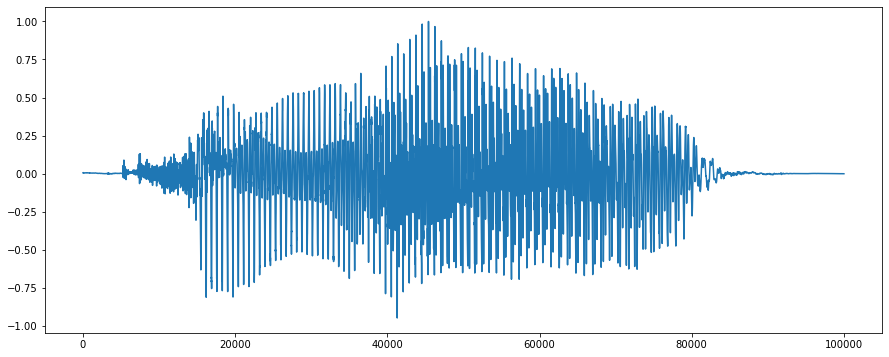

In [41]:
import numpy as np
from scipy.io import wavfile

# Load the WAV file
file_path = 'hello.wav'
sample_rate, data = wavfile.read(file_path)

# Print out the sample rate and the shape of the numpy array
print("Sample Rate:", sample_rate)
print("Data Shape:", data.shape)
data_t = torch.from_numpy(np.linspace(1,100_000,data.shape[0]))
max_amp = max(abs(data))
data= data/max_amp
##data = data.detach().numpy().astype(np.float64)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')



In [8]:
data = generate_gaussian_noise(data, mean=0, std_dev=1)

In [129]:
dataset = WaveformDataset(data, data_t)
batch_size = 200
consecutive_size = 10

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)

In [174]:
num_layers = 50 # Let's say we want 5 layers in the network
model = WeirdSinNetworkInit1(num_layers,max_amp)

In [181]:
num_layers = 50 # Let's say we want 5 layers in the network
model = WeirdSinNetwork(num_layers)

In [287]:
model = WeirdSinPaintNetwork(num_layers = 10, embedding_dim = 100) #this one is documented well.  4100

In [309]:
model = WeirdSinPaintNetwork2(num_layers = 10, embedding_dim = 20) #this is 820 params i think

NameError: name 'WeirdSinPaintNetwork2' is not defined

In [316]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have defined your model, loss function, and optimizer
# Example:
# model = YourModel()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)
#ConsecutiveDifferenceLoss(consecutive_size)  #ConsecutiveDifferenceLossAndBatch(consecutive_size) #  consecutive_dif(prediction, target, consecutive_size)
mse_loss = WeightedMSELoss(max_amp) #nn.MSELoss() #ConsecutiveSlopeWeightedMSELoss(consecutive_size) #
optimizer = optim.Adam(model.parameters(), lr=0.0009)


#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.001, step_size_up=100, mode='triangular', cycle_momentum=False)

# Training loop
num_epochs = 20  # Set the number of epochs
model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, ( targets,inputs) in enumerate(data_loader):
        # Move data to the appropriate device (GPU/CPU)
        #inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        mse = mse_loss(outputs, targets.unsqueeze(-1))
        cdif = cdif_loss(outputs, targets)
        cdif_b = cdifb_loss(outputs, targets)
        loss =    0.6*cdif + 0.2*cdif_b + 0.5 * mse

        loss.backward()
        optimizer.step()
        #scheduler.step()
        # Print statistics
        running_loss += loss.item()
    
    if epoch % 5 == 4:  # Print every 10 mini-batches
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / 10:.4f}')
    running_loss = 0.0
        
print('Training finished.')


Epoch [5/20], Loss: 7895.9083
Epoch [10/20], Loss: 7866.1942
Epoch [15/20], Loss: 7651.9252
Epoch [20/20], Loss: 7491.5045
Training finished.


In [317]:
model.embedding

tensor([[   6.1320],
        [  34.3353],
        [  15.6784],
        [-132.1092],
        [ -60.2050],
        [ 167.5126],
        [ -22.9266],
        [ -11.8581],
        [ -70.8056],
        [ -56.5024],
        [  41.7878],
        [ -61.7739],
        [-154.9684],
        [-284.9509],
        [-201.7662],
        [  18.0895],
        [ 193.4893],
        [ -52.0570],
        [ -87.4545],
        [-115.6613]], dtype=torch.float64, grad_fn=<ToCopyBackward0>)

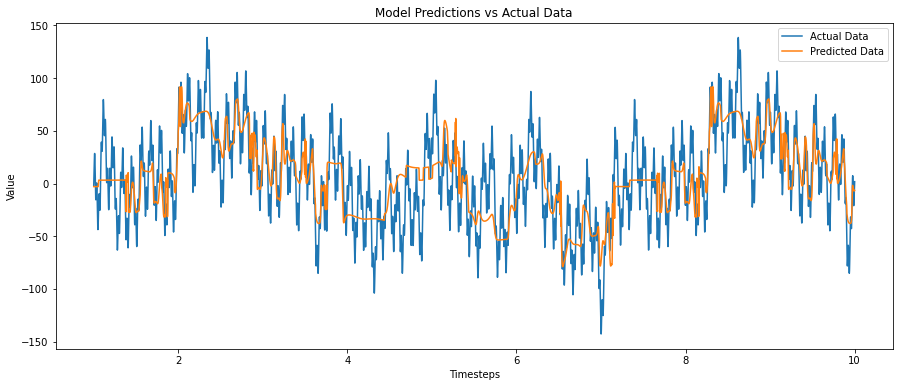

In [318]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Assuming data contains the targets and data_t contains the input timesteps
data_loader_eval = DataLoader(WaveformDataset(data, data_t), batch_size=50, shuffle=False)

with torch.no_grad():
    predictions = []
    actuals = []
    timesteps = []
    for  batch_data,batch_t in data_loader_eval:
        #batch_t, batch_data = batch_t.to(device), batch_data.to(device)
        outputs = model(batch_t)
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_data.cpu().numpy())
        timesteps.append(batch_t.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)
timesteps = np.concatenate(timesteps, axis=0)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot( timesteps.flatten(),actuals.flatten(), label='Actual Data')
plt.plot( timesteps.flatten(),predictions.flatten(), label='Predicted Data')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.title('Model Predictions vs Actual Data')
plt.show()


In [306]:
model = WeirdSinPaintNetwork(num_layers = 20, embedding_dim = 20) #this one is documented well.  1620 params

In [312]:
########updates AFTER all gradients accumulated. 

# Assuming you have defined your model, loss function, and optimizer
# Example:
# model = YourModel()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)
#ConsecutiveDifferenceLoss(consecutive_size)  #ConsecutiveDifferenceLossAndBatch(consecutive_size) #  consecutive_dif(prediction, target, consecutive_size)
mse_loss = WeightedMSELoss(max_amp) #nn.MSELoss() #ConsecutiveSlopeWeightedMSELoss(consecutive_size) #
optimizer = optim.Adam(model.parameters(), lr=0.001)


scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.0001, step_size_up=100, mode='triangular', cycle_momentum=False)

# Training loop
num_epochs = 100  # Set the number of epochs
model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    
    optimizer.zero_grad()
    for batch_idx, ( targets,inputs) in enumerate(data_loader):
        # Move data to the appropriate device (GPU/CPU)
        #inputs, targets = inputs.to(device), targets.to(device)



        # Forward pass
        outputs = model(inputs)
        mse = mse_loss(outputs, targets.unsqueeze(-1))
        cdif = cdif_loss(outputs, targets)
        cdif_b = cdifb_loss(outputs, targets)
        loss =    0.6*cdif + 0.2*cdif_b + 0.5 * mse

        loss.backward()
        
        
        # Print statistics
        running_loss += loss.item()
    
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    if epoch % 5 == 4:  # Print every 10 mini-batches
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / 10:.4f}')
    running_loss = 0.0
        
print('Training finished.')


Epoch [5/100], Loss: 13104.8542
Epoch [10/100], Loss: 12295.8699
Epoch [15/100], Loss: 12118.1459
Epoch [20/100], Loss: 12033.2818
Epoch [25/100], Loss: 12059.1116
Epoch [30/100], Loss: 11593.0806
Epoch [35/100], Loss: 11295.1731
Epoch [40/100], Loss: 11196.4359
Epoch [45/100], Loss: 11145.7586


KeyboardInterrupt: 